In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import random
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import FileLink
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Функция для создания DataFrame с подклассами, на основе имён директорий
def collect_file_info(root_dir):
    file_info = []
    for main_class in os.listdir(root_dir):
        main_class_path = os.path.join(root_dir, main_class)
        if os.path.isdir(main_class_path):
            for file_name in os.listdir(main_class_path):
                file_path = os.path.join(main_class_path, file_name)
                if os.path.isfile(file_path):
                    file_info.append({
                        'path': file_path,
                        'label': main_class,
                        'sub_class': main_class
                    })
    
    return file_info

In [3]:
# Путь до корневой папки датасета и создание DataFrame
root_dir = '/kaggle/input/wolf-dog-val/val_dataset'
file_info = collect_file_info(root_dir)
df = pd.DataFrame(file_info)
df['label'].unique()

array(['wolf', 'dog', 'negative'], dtype=object)

In [4]:
class_counts = df['label'].value_counts()
print("Количество элементов в каждом классе:")
print(class_counts)
df.head(5)

Количество элементов в каждом классе:
label
negative    364
dog         349
wolf        193
Name: count, dtype: int64


,path,label,sub_class
0,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,wolf,wolf
1,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,wolf,wolf
2,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,wolf,wolf
3,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,wolf,wolf
4,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,wolf,wolf


In [5]:
df.to_csv('file_info.csv', index=False)
df = pd.read_csv("/kaggle/working/file_info.csv")

In [6]:
# Создания словаря для преобразования меток классов числовые значения
class_names = df['label'].unique()
class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
class_dict = {'wolf': 2, 'dog': 1, 'negative': 0}
print("\nClass dictionary:")
print(class_dict)


Class dictionary:
{'wolf': 2, 'dog': 1, 'negative': 0}


In [7]:
print(df['label'].value_counts())
df['label'] = df['label'].map(class_dict)
print(df['label'].value_counts())
df.head(5)

label
negative    364
dog         349
wolf        193
Name: count, dtype: int64
label
0    364
1    349
2    193
Name: count, dtype: int64


,path,label,sub_class
0,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,2,wolf
1,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,2,wolf
2,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,2,wolf
3,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,2,wolf
4,/kaggle/input/wolf-dog-val/val_dataset/wolf/wo...,2,wolf


In [8]:
# Балансировка количества сэмплов по классам
wolf_count = df[df['label'] == 2].shape[0]
balanced_negative = df[df['label'] == 0].sample(wolf_count, random_state=42)
balanced_dog = df[df['label'] == 1].sample(wolf_count, random_state=42)
balanced_wolf = df[df['label'] == 2]
balanced_df = pd.concat([balanced_negative, balanced_dog, balanced_wolf]).reset_index(drop=True)
print(len(balanced_negative), len(balanced_dog), len(balanced_wolf))
balanced_df['label'].value_counts()

193 193 193


label
0    193
1    193
2    193
Name: count, dtype: int64

In [9]:
data = balanced_df
data['label'].value_counts()

label
0    193
1    193
2    193
Name: count, dtype: int64

In [10]:
# Датасет
class CustomAudioDataset(Dataset):
    def __init__(self, paths, labels, rate, target_length=480000, transform=None):
        self.paths = paths
        self.labels = labels
        self.rate = rate
        self.target_length = target_length
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        waveform = self.length_processing(idx)
        if self.transform:
            waveform = self.transform(waveform)
        label = self.labels[idx]
        return waveform, label, idx
    # Приведение к нужным хар-кам и длине
    def length_processing(self, idx):
        waveform, sample_rate = torchaudio.load(self.paths[idx])
        waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != self.rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.rate)
        current_length = waveform.shape[1]
        if current_length > self.target_length:
            waveform = waveform[:, :self.target_length]
        elif current_length < self.target_length:
            waveform = torch.nn.functional.pad(waveform, (0, self.target_length - current_length))
        return waveform.mean(dim=0)

In [11]:
test_audio_dataset = CustomAudioDataset(data["path"].tolist(), data["label"].tolist(), 16000)
test_dataloader = DataLoader(test_audio_dataset, batch_size=4, shuffle=False)
len(test_dataloader)

145

In [12]:
# Получение модели
bundle = torchaudio.pipelines.WAV2VEC2_BASE
model = bundle.get_model()

# Класс модели
class CustomAudioModel(nn.Module):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.num_features = model.encoder.transformer.layers[-1].final_layer_norm.normalized_shape[0]
        self.linear_stack = nn.Sequential(
            nn.Linear(self.num_features, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_classes),
        )
    def forward(self, x):
        x = self.model(x)
        x = x[0].mean(dim=1)
        x = self.linear_stack(x)
        return x

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 243MB/s]


In [13]:
# Получение метрик по классам
def compute_metrics(preds, labels):
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1, 2])
    return p, r, f1

# Функция для тестирования
def eval_epoch(model, loss_fn, dataloader):
    model.eval()
    sum_recall = 0
    sum_precision = 0
    sum_f1 = 0
    sum_loss = 0
    all_preds = []
    all_labels = []
    pbar = tqdm(dataloader, ascii=True, desc='Val')
    with torch.no_grad():
        for i, (samples, labels, idx) in enumerate(pbar):
            samples, labels = samples.to(device), labels.to(device)
            pred = model(samples)
            loss = loss_fn(pred, labels)
            sum_loss += loss.item()
            
            _, predicted_labels = torch.max(pred, 1)
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            precision = precision_score(labels.cpu(), predicted_labels.cpu(), zero_division=0, average='micro')
            recall = recall_score(labels.cpu(), predicted_labels.cpu(), zero_division=0, average='micro')
            f1 = f1_score(labels.cpu(), predicted_labels.cpu(), zero_division=0, average='micro')
            sum_precision += precision
            sum_recall += recall
            sum_f1 += f1
            
    avg_recall = sum_recall / len(dataloader)
    avg_precision = sum_precision / len(dataloader)
    avg_f1 = sum_f1 / len(dataloader)
    avg_loss = sum_loss / len(dataloader)
    print(f"Eval Loss: {avg_loss}")
    precision, recall, f1 = compute_metrics(all_preds, all_labels)
    for j, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {j} - Precision: {p:.4f}, Recall: {r:.4f}, F1-score: {f:.4f}")
    print(f"Average - Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1 score: {avg_f1:.4f}")
    return avg_loss, all_preds, all_labels

In [14]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
device

'cuda:0'

# Testing

In [15]:
torch.cuda.empty_cache()
custom_model = CustomAudioModel(model, 3)
custom_model = custom_model.to(device)

weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
loss_function = nn.CrossEntropyLoss(weight=weights)

model_path = "/kaggle/input/wolf_dog_sound_recognition/pytorch/filtred_wolf_no_weights_not_full_zero/1/best_model (2).pth"
custom_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
val_loss, all_preds, all_labels = eval_epoch(custom_model, loss_function, test_dataloader)

Val:   0%|          | 0/145 [00:00<?, ?it/s]

Eval Loss: 0.5459689466957132
Class 0 - Precision: 0.7988, Recall: 0.6788, F1-score: 0.7339
Class 1 - Precision: 1.0000, Recall: 0.8446, F1-score: 0.9157
Class 2 - Precision: 0.7381, Recall: 0.9637, F1-score: 0.8360
Average - Precision: 0.8293, Recall: 0.8293, F1 score: 0.8293


# Confusion matrix

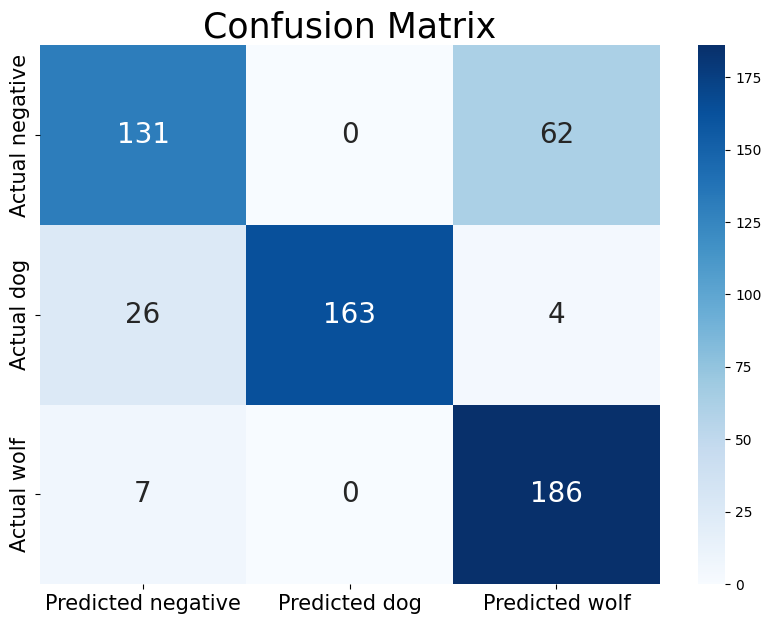

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted negative', 'Predicted dog', 'Predicted wolf'], yticklabels=['Actual negative', 'Actual dog', 'Actual wolf'], annot_kws={"size": 20})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=25)
plt.show()